In [28]:
import concurrent.futures
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from tqdm import tqdm

# visuals.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [67]:
def read_df(path):
    try:
        return pd.read_csv(path)
    except Exception as err:
        print(err)


df = []
files = list(Path("./trades/").glob("*.csv"))
with concurrent.futures.ThreadPoolExecutor() as executor:
    df.extend(tqdm(executor.map(read_df, files), total=len(files)))
df = pd.concat(df, ignore_index=True)

df["date"] = pd.to_datetime(df["date"])
df.sort_values(["date", "ticker"], inplace=True)
df

100%|██████████| 11/11 [00:00<00:00, 817.79it/s]


,fund,date,direction,ticker,cusip,company,shares,% of etf
51,ARKW,2021-02-01,Sell,API,00851L103,AGORA INC,54100,0.0577
44,ARKQ,2021-02-01,Sell,AVAV,008073108,AEROVIRONMENT INC,6132,0.0241
31,ARKK,2021-02-01,Buy,BEAM,07373V105,BEAM THERAPEUTICS INC,58218,0.0241
48,ARKW,2021-02-01,Buy,BEKE,482497104,KE HOLDINGS INC,110900,0.0986
47,ARKQ,2021-02-01,Sell,BYDDY,05606L100,BYD CO LTD,31503,0.0671
...,...,...,...,...,...,...,...,...
221,ARKQ,2021-02-16,Sell,TSM,874039100,TAIWAN SEMICONDUCTOR MANUFACTURING CO LTD,71667,0.2480
200,ARKG,2021-02-16,Sell,TWST,90184D100,TWIST BIOSCIENCE CORP,1646,0.0021
203,ARKG,2021-02-16,Sell,VCYT,92337F107,VERACYTE INC,21481,0.0129
197,ARKG,2021-02-16,Buy,VEEV,922475108,VEEVA SYSTEMS INC,17771,0.0447


In [63]:
# open prices of traded stocks
open_configs = [{"ticker":ticker, "start_date":df["date"].min(), "end_date":df["date"].max(), "on":"Open"} for ticker in df["ticker"].unique()] # on ark's trade date

def parallel_fetch_daily_data(config):
    try:
        # fetch daily market data from yahoo finance
        df = web.get_data_yahoo(config["ticker"], start=config["start_date"], end=config["end_date"])[[config["on"]]]
        df["ticker"] = config["ticker"]
        df.drop_duplicates(inplace=True)
        return df
    except Exception as e:
        print(e)


open_prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    open_prices.extend(executor.map(parallel_fetch_daily_data, open_configs))
open_prices = pd.concat(open_prices)
open_prices.reset_index(inplace=True)

# make key
open_prices["key1"] = open_prices["ticker"].astype(str) + "_" + open_prices["Date"].astype(str)
open_prices.set_index("key1", inplace=True)
open_prices

No data fetched for symbol 1833 using YahooDailyReader
No data fetched for symbol 3690 using YahooDailyReader
No data fetched for symbol ADYEN using YahooDailyReader


,Date,Open,ticker
key1,,,
API_2021-02-01,2021-02-01,72.080002,API
API_2021-02-02,2021-02-02,80.000000,API
API_2021-02-03,2021-02-03,78.000000,API
API_2021-02-04,2021-02-04,93.489998,API
API_2021-02-05,2021-02-05,87.190002,API
...,...,...,...
VEEV_2021-02-09,2021-02-09,297.570007,VEEV
VEEV_2021-02-10,2021-02-10,306.420013,VEEV
VEEV_2021-02-11,2021-02-11,313.799988,VEEV


In [68]:
# net & volume of trades (assume on open price)
net = df.copy()[["fund", "date", "direction", "ticker", "company", "shares"]]
net["shares"] = net.apply(lambda row:row["shares"] if row["direction"]=="Buy" else -row["shares"], axis=1)
net = net.groupby(["ticker", "date", "company", "fund"], as_index=False).agg({'shares':'sum'}) # total shares per ticker per date

# make key
net["key1"] = net["ticker"].astype(str) + "_" + net["date"].astype(str)
net.set_index("key1", inplace=True)

# link to price
net = net.join(open_prices[["Open"]], how="inner")

# new cols
net["signal"] = net["shares"].apply(lambda x: "Buy" if x>0 else "Sell")
net["volume"] = net["shares"] * net["Open"]
net["abs_volume"] = abs(net["volume"])

net

,ticker,date,company,fund,shares,Open,signal,volume,abs_volume
key1,,,,,,,,,
ABBV_2021-02-16,ABBV,2021-02-16,ABBVIE INC,ARKG,121900,105.330002,Buy,1.283973e+07,1.283973e+07
ACIC_2021-02-16,ACIC,2021-02-16,ATLAS CREST INVESTMENT CORP,ARKQ,372574,14.870000,Buy,5.540175e+06,5.540175e+06
AMZN_2021-02-16,AMZN,2021-02-16,AMAZON.COM INC,ARKQ,1875,3254.050049,Buy,6.101344e+06,6.101344e+06
API_2021-02-01,API,2021-02-01,AGORA INC,ARKW,-54100,72.080002,Sell,-3.899528e+06,3.899528e+06
API_2021-02-05,API,2021-02-05,AGORA INC,ARKW,-120800,87.190002,Sell,-1.053255e+07,1.053255e+07
...,...,...,...,...,...,...,...,...,...
VRTX_2021-02-02,VRTX,2021-02-02,VERTEX PHARMACEUTICALS INC,ARKG,81700,225.800003,Buy,1.844786e+07,1.844786e+07
VRTX_2021-02-03,VRTX,2021-02-03,VERTEX PHARMACEUTICALS INC,ARKG,57100,218.419998,Buy,1.247178e+07,1.247178e+07
VRTX_2021-02-05,VRTX,2021-02-05,VERTEX PHARMACEUTICALS INC,ARKG,111700,214.500000,Buy,2.395965e+07,2.395965e+07


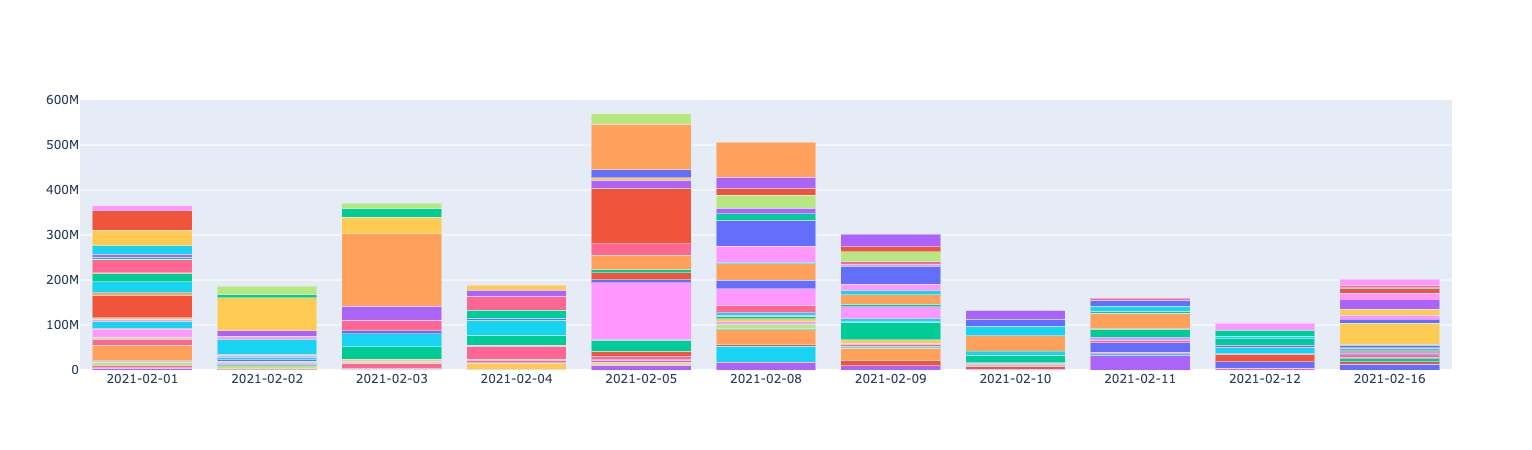

In [76]:
# group bar chart
def group_bc_traces(x, y, hue, groups, df, agg=np.sum, legend=False):
    # creates a grouped barchart according to hue (color)
    
    groups = groups.copy()
    groups.append(hue)
    groups_df = df.groupby(groups).agg(agg).reset_index()
    
    traces = []
    for v in df[hue].unique():
        trace = go.Bar(name=v, showlegend=legend, x=groups_df[groups_df[hue]==v][x].astype(str), y=groups_df[groups_df[hue]==v][y])
        traces.append(trace)
        
    return traces

def plot_traces(traces):
    # plots several traces
    fig = go.Figure()
    
    for t in traces:
        fig.add_trace(t)
        
    return fig

traces = group_bc_traces("date", "abs_volume", "ticker", ["date"], net)
fig = plot_traces(traces)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending', 'type': 'category'})

fig



In [74]:
len(traces)

69